In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

# <h2>Exact Duplicates Investigation</h2>

In [2]:
#tactics_data = pd.read_csv("/h/224/stevenhl/modified tactics data.csv")
#tactics_data

,tactics_problem_id,rating,rd,attempt_count,average_seconds,move_count,tags,pgn,FULL,FEN,Event,Site,Date,Round,White,Black,Result,FirstMove,PlyCount,SetUp
0,731,1569,44.96,53336,41,3,"Attacking f7/f2,Attacking Castled King,Back Ra...","[Event ""?""]\n[Site ""?""]\n[Date ""????.??.??""]\n...",1. ... gxf6 2. Qxf8+ Kxf8 3. Bh6+ Kg8 4. Re8#,r1b2rk1/ppp2ppp/1b3N2/3q4/3p4/Q4N2/PPP2KPP/R1...,?,?,????.??.??,?,?,?,1-0,1b,6.0,1.0
1,732,1417,45.44,63725,26,2,"Basic Checkmates,Decoy / Deflection,Mate in 2,...","[Event ""?""]\n[Site ""?""]\n[Date ""????.??.??""]\n...",1. ... Rag8 2. Qxh7+ Rxh7 3. Rxg8#,r6k/1q1n1prp/p3pN1Q/1p1b4/6R1/6P1/PP2PP1P/3R2...,?,?,????.??.??,?,?,?,1-0,1b,4.0,1.0
2,738,2443,44.59,18115,54,3,"Back Rank,Discovered Attack,Fork / Double Atta...","[Event ""?""]\n[Site ""?""]\n[Date ""????.??.??""]\n...",1. Kxf1 Nd2+ 2. Kg1 Re1+ 3. Kh2 Nf1+,3rr1k1/ppp2ppp/8/5Q2/4n3/1B5R/PPP2PP1/5qK1 w ...,?,?,????.??.??,?,?,?,*,NaN,6.0,1.0
3,739,1795,44.97,41674,57,3,"Discovered Attack,Mate in 3+,Mating Net,Cleara...","[Event ""?""]\n[Site ""?""]\n[Date ""????.??.??""]\n...",1. ... Kf8 2. Qh8+ Ke7 3. Nf5+ exf5 4. Bc5#,3r2k1/pb1q1ppQ/1p2pb1p/8/3N4/P3B3/1P3PPP/1Br1...,?,?,????.??.??,?,?,?,1-0,1b,6.0,1.0
4,740,2148,45.14,25701,88,5,"Discovered Attack,Mate in 3+,Mating Net,Double...","[Event ""?""]\n[Site ""?""]\n[Date ""????.??.??""]\n...",1. ... Kxd8 2. Nxe6+ Ke7 3. Bg5+ f6 4. Nd8+ R...,3Qkb1r/pp3ppp/q3b3/8/1n1N4/2r1B3/PPP2PPP/2KRR...,?,?,????.??.??,?,?,?,1-0,1b,10.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54801,661058,2364,79.76,470,84,4,"Mate in 3+,Mating Net,Overloading","[Event ""Blitz (3-minute)""]\n[Site ""Chess.com""]...",NaN,3rk1r1/5p1R/4q1p1/1Np1b3/Q7/1P2P3/P3K3/5R2 b ...,Blitz (3-minute),Chess.com,2018.04.21,?,"Naroditsky, Daniel",?,1-0,NaN,NaN,NaN
54802,661060,2526,93.04,310,88,2,"Hanging Piece,Trapped Piece","[Event ""?""]\n[Site ""?""]\n[Date ""????.??.??""]\n...",NaN,5rk1/p2br1pp/1p1qpn2/2bp4/3B1P2/2P2NP1/PP2Q1B...,?,?,????.??.??,?,?,?,*,NaN,NaN,1.0
54803,661062,945,144.50,1032,38,2,NaN,"[Event ""?""]\n[Site ""?""]\n[Date ""????.??.??""]\n...",NaN,5r2/8/p2pBbkp/3P2p1/3n4/B7/P4PPP/4R1K1 b - - ...,?,?,????.??.??,?,MikeySlice,Berlaga96,1-0,NaN,NaN,NaN
54804,661064,1444,66.55,918,65,3,NaN,"[Event ""Berlin Match 1851""]\n[Site ""?""]\n[Date...",NaN,r1b2r2/pp4k1/1bpp1q1p/5ppQ/2B2NN1/2P5/P5PP/R1...,Berlin Match 1851,?,????.??.??,?,Adolf Anderssen,Carl Mayet,1-0,NaN,NaN,NaN


In [173]:
tactics_data = pd.read_csv('/w/225/1/chess/tactics/tactics_problem.csv')
tactics_data

,tactics_problem_id,rating,rd,attempt_count,average_seconds,move_count,tags,pgn
0,731,1569,44.96,53336,41,3,"Attacking f7/f2,Attacking Castled King,Back Ra...","[Event ""?""]\n[Site ""?""]\n[Date ""????.??.??""]\n..."
1,732,1417,45.44,63725,26,2,"Basic Checkmates,Decoy / Deflection,Mate in 2,...","[Event ""?""]\n[Site ""?""]\n[Date ""????.??.??""]\n..."
2,738,2443,44.59,18115,54,3,"Back Rank,Discovered Attack,Fork / Double Atta...","[Event ""?""]\n[Site ""?""]\n[Date ""????.??.??""]\n..."
3,739,1795,44.97,41674,57,3,"Discovered Attack,Mate in 3+,Mating Net,Cleara...","[Event ""?""]\n[Site ""?""]\n[Date ""????.??.??""]\n..."
4,740,2148,45.14,25701,88,5,"Discovered Attack,Mate in 3+,Mating Net,Double...","[Event ""?""]\n[Site ""?""]\n[Date ""????.??.??""]\n..."
...,...,...,...,...,...,...,...,...
54801,661058,2364,79.76,470,84,4,"Mate in 3+,Mating Net,Overloading","[Event ""Blitz (3-minute)""]\n[Site ""Chess.com""]..."
54802,661060,2526,93.04,310,88,2,"Hanging Piece,Trapped Piece","[Event ""?""]\n[Site ""?""]\n[Date ""????.??.??""]\n..."
54803,661062,945,144.50,1032,38,2,NaN,"[Event ""?""]\n[Site ""?""]\n[Date ""????.??.??""]\n..."
54804,661064,1444,66.55,918,65,3,NaN,"[Event ""Berlin Match 1851""]\n[Site ""?""]\n[Date..."


In [174]:
#a function to extract ONLY the field indicated by parameter if it exists. Otherwise, it's skipped
def extract(st, parameter):
    splitted_st = st.split("\\n") #splitted strings
    existence = 0
    for string in splitted_st:
        if parameter in string: #if we find the section which has parameter in it (as the indicator)
            target_st = string #take it as our target string
            existence = 1 #to denote that the parameter field indeed exists
            break
    if existence == 1: #if the parameter field exists, clean it up so that we get only the relevant information. Otherwise, skip
        target_st = target_st.replace(parameter, '')
        target_st = target_st.replace('[','')
        target_st = target_st.replace(']','')
        target_st = target_st.replace('"','')
        return target_st #return the cleaned target string if the parameter field exists
    return "N/A" #return N/A if the parameter field does not exist

In [175]:
#Create a FULL column, append it to the tactics_data. Repeat this same process for FEN, Event, and so on.


tactics_data['FULL'] = 'N/A'
tactics_data['FEN'] = 'N/A'
tactics_data['Event'] = 'N/A'
tactics_data['Site'] = 'N/A'
tactics_data['Date'] = 'N/A'
tactics_data['Round'] = 'N/A'
tactics_data['White'] = 'N/A'
tactics_data['Black'] = 'N/A'
tactics_data['Result'] = 'N/A'
tactics_data['FirstMove'] = 'N/A'
tactics_data['PlyCount'] = 'N/A'
tactics_data['SetUp'] = 'N/A' 

row, col = tactics_data.shape
puzz_id = list(tactics_data['tactics_problem_id'])
for i in tqdm(range(row)):
    pos = puzz_id.index(tactics_data.iloc[i,0])
    pgn = tactics_data.iloc[pos,7]
    tactics_data.iloc[i,8] = extract(pgn, "FULL")
    tactics_data.iloc[i,9] = extract(pgn, "FEN")
    tactics_data.iloc[i,10] = extract(pgn, "Event")
    tactics_data.iloc[i,11] = extract(pgn, "Site")
    tactics_data.iloc[i,12] = extract(pgn, "Date")
    tactics_data.iloc[i,13] = extract(pgn, "Round")
    tactics_data.iloc[i,14] = extract(pgn, "White")
    tactics_data.iloc[i,15] = extract(pgn, "Black")
    tactics_data.iloc[i,16] = extract(pgn, "Result")
    tactics_data.iloc[i,17] = extract(pgn, "FirstMove")
    tactics_data.iloc[i,18] = extract(pgn, "PlyCount")
    tactics_data.iloc[i,19] = extract(pgn, "SetUp")

KeyboardInterrupt: 

In [3]:
#A list of ALL the cleaned FEN and cleaned FULL fields in the form of (FEN, FULL) tuple, EXCLUDING N/A's.

full_list_ori = np.array(tactics_data['FULL'])
fen_list_ori = np.array(tactics_data['FEN'])
fen_full_list_cleaned = []
for i in range(len(full_list_ori)):
    if full_list_ori[i] != 'N/A' and fen_list_ori[i] != 'N/A':
        fen_full_list_cleaned.append((fen_list_ori[i], full_list_ori[i]))

In [4]:
#fen_full_to_ids is a dictionary that maps (FEN, FULL) tuple to ALL OF ITS CORRESPONDING PROBLEM IDs,
#which are colleted in a list

fen_full_to_ids = {}
for fen_full in fen_full_list_cleaned:
    fen_full_to_ids[fen_full] = []
    
r,c = tactics_data.shape
for i in tqdm(range(r)):
    fen = tactics_data.iloc[i,9]
    full = tactics_data.iloc[i,8]
    prob_id = tactics_data.iloc[i,0]
    if full != "N/A" and fen != "N/A":
        fen_full_to_ids[(fen,full)].append(prob_id)

In [5]:
#dup_fen_full_to_ids is a subset of fen_full_to_ids. Here, only ids which have at least 1 duplicate are selected.
dup_fen_full_to_ids = {}

for pair in fen_full_to_ids:
    if len(fen_full_to_ids[pair]) > 1:
        dup_fen_full_to_ids[pair] = fen_full_to_ids[pair]

In [6]:
dup_fen_full_to_ids

{(' r1bqk2r/pppn1pp1/5n1p/2B5/2B1Q3/2N5/PPP3PP/R4RK1 b kq - 1 1',
  ' 1. ... Nxe4 2. Bxf7#'): [752, 765],
 (' r1bqkb1r/pppp1ppp/2n2n2/4p1N1/2B1P3/8/PPPP1PPP/RNBQK2R b KQkq -',
  ' 4. ... h6 5. Nxf7 Qe7 6. Nxh8'): [26689, 56297, 65759, 97621, 112114],
 (' rnbqkbnr/pppp2pp/5p2/4P3/4P3/8/PPP2PPP/RNBQKBNR b KQkq -',
  ' 3. ... fxe5 4. Qh5+ g6 5. Qxe5+ Qe7 6. Qxh8'): [26857,
  64496,
  117179,
  134743,
  188313],
 (' r1bqkb1r/ppp2ppp/2n5/3np3/2B5/5N2/PPPP1PPP/RNBQR1K1 b kq -',
  ' 6. ... Bd6 7. Bxd5'): [27087, 114554],
 (' rnb1kbnr/ppp1pppp/4q3/8/8/2N5/PPPPBPPP/R1BQK1NR b KQkq -',
  ' 4. ... Qc6 5. Bb5 Bd7 6. Bxc6'): [27215, 49818, 118092],
 (' r1bqkbnr/pp1p1ppp/2n5/4p3/2P5/2Q5/PP2PPPP/RNB1KBNR w KQkq e6',
  ' 5. Nf3 Bb4 6. Bd2 Bxc3'): [27455, 182138],
 (' 6n1/3r3k/p4p2/1pp2NpP/6P1/2P2Q2/PP3RK1/4q3 b - -',
  ' 36. ... Rd1 37. Qb7+ Ne7 38. Qxe7+ Qxe7 39. Nxe7'): [27720, 128972],
 (' 2r5/2p4p/1p3k2/1P1b1p2/r7/3P1N2/6PP/1R2R2K w - -',
  ' 36. Re5 Bxf3 37. gxf3 Kxe5'): [27850, 35824],
 (' 2r5/

In [7]:
#duplicate_fen_full_id_to_id is a list that pairs an ID to another (FEN,FULL) duplicate ID in the form of tuple. If there are more than two
#problems which are duplicate to each other, we form every possible 2-way pair of all the IDs.
duplicate_fen_full_id_to_id = []
#target_problems is a list of all the problems which have at least one duplicate and so 
#we have to assess for their (reciprocal) rank
target_problems = []
#dup_fen_full_list is a list that pairs FEN and FULL in the form of (FEN, FULL) tuple, but ONLY those which have duplicates.
dup_fen_full_list = []
#group is a list to denote the "group" of each problem id. Here, group denotes which ones are duplicate with each other
#Ex:
#752 -> group 1
#765 -> group 1
#This means 752 and 765 are exact duplicates (exactly same FEN and FULL) with each other
group = []
#ind is just index for the group list.
ind = 0

for fen_full in dup_fen_full_to_ids: #for every (FEN,FULL) field
    prob_id_list = dup_fen_full_to_ids[fen_full] #get the list of corresponding problem IDs
    target_problems += prob_id_list #add that ID to the target_problems list
    ind += 1
    #create all pairs of IDs in the list
    for k in range(len(prob_id_list)):
        group.append(ind)
        dup_fen_full_list.append(fen_full)
        for j in range(len(prob_id_list)):
            if prob_id_list[k] != prob_id_list[j]:
                duplicate_fen_full_id_to_id.append((prob_id_list[k],prob_id_list[j]))

In [8]:
dup_fen_full_list

[(' r1bqk2r/pppn1pp1/5n1p/2B5/2B1Q3/2N5/PPP3PP/R4RK1 b kq - 1 1',
  ' 1. ... Nxe4 2. Bxf7#'),
 (' r1bqk2r/pppn1pp1/5n1p/2B5/2B1Q3/2N5/PPP3PP/R4RK1 b kq - 1 1',
  ' 1. ... Nxe4 2. Bxf7#'),
 (' r1bqkb1r/pppp1ppp/2n2n2/4p1N1/2B1P3/8/PPPP1PPP/RNBQK2R b KQkq -',
  ' 4. ... h6 5. Nxf7 Qe7 6. Nxh8'),
 (' r1bqkb1r/pppp1ppp/2n2n2/4p1N1/2B1P3/8/PPPP1PPP/RNBQK2R b KQkq -',
  ' 4. ... h6 5. Nxf7 Qe7 6. Nxh8'),
 (' r1bqkb1r/pppp1ppp/2n2n2/4p1N1/2B1P3/8/PPPP1PPP/RNBQK2R b KQkq -',
  ' 4. ... h6 5. Nxf7 Qe7 6. Nxh8'),
 (' r1bqkb1r/pppp1ppp/2n2n2/4p1N1/2B1P3/8/PPPP1PPP/RNBQK2R b KQkq -',
  ' 4. ... h6 5. Nxf7 Qe7 6. Nxh8'),
 (' r1bqkb1r/pppp1ppp/2n2n2/4p1N1/2B1P3/8/PPPP1PPP/RNBQK2R b KQkq -',
  ' 4. ... h6 5. Nxf7 Qe7 6. Nxh8'),
 (' rnbqkbnr/pppp2pp/5p2/4P3/4P3/8/PPP2PPP/RNBQKBNR b KQkq -',
  ' 3. ... fxe5 4. Qh5+ g6 5. Qxe5+ Qe7 6. Qxh8'),
 (' rnbqkbnr/pppp2pp/5p2/4P3/4P3/8/PPP2PPP/RNBQKBNR b KQkq -',
  ' 3. ... fxe5 4. Qh5+ g6 5. Qxe5+ Qe7 6. Qxh8'),
 (' rnbqkbnr/pppp2pp/5p2/4P3/4P3/8/PPP2PPP/RNBQKB

In [9]:
new_table_fen_full_pair = tactics_data.set_index("tactics_problem_id", inplace = False)
new_table_fen_full_pair = new_table_fen_full_pair.loc[target_problems]
new_table_fen_full_pair.insert(0, "(FEN,FULL)", dup_fen_full_list)
new_table_fen_full_pair.insert(0, "Group", group)

In [10]:
new_table_fen_full_pair.to_csv("new_tactics_problem.csv")

In [11]:
temp = pd.read_csv("new_tactics_problem.csv")
temp

,tactics_problem_id,Group,"(FEN,FULL)",rating,rd,attempt_count,average_seconds,move_count,tags,pgn,...,Event,Site,Date,Round,White,Black,Result,FirstMove,PlyCount,SetUp
0,752,1,(' r1bqk2r/pppn1pp1/5n1p/2B5/2B1Q3/2N5/PPP3PP/...,732,42.13,37174,19,1,Mate in 1,"[Event ""?""]\n[Site ""?""]\n[Date ""????.??.??""]\n...",...,?,?,????.??.??,?,?,?,1-0,1b,2.0,1.0
1,765,1,(' r1bqk2r/pppn1pp1/5n1p/2B5/2B1Q3/2N5/PPP3PP/...,588,42.31,45728,18,1,Mate in 1,"[Event ""?""]\n[Site ""?""]\n[Date ""????.??.??""]\n...",...,?,?,????.??.??,?,?,?,1-0,1b,2.0,1.0
2,26689,2,(' r1bqkb1r/pppp1ppp/2n2n2/4p1N1/2B1P3/8/PPPP1...,429,40.58,26072,20,2,Fork / Double Attack,"[Event ""Online Chess""]\n[Site ""Chess.com""]\n[D...",...,Online Chess,Chess.com,2007.07.28,1,o0obruceleeo0o,BrianAB,1-0,4b,4.0,1.0
3,56297,2,(' r1bqkb1r/pppp1ppp/2n2n2/4p1N1/2B1P3/8/PPPP1...,400,41.00,22640,37,2,Fork / Double Attack,"[Event ""Online Chess""]\n[Site ""Chess.com""]\n[D...",...,Online Chess,Chess.com,2007.09.05,1,bat4uo,okmrbill,0-1,4b,4.0,1.0
4,65759,2,(' r1bqkb1r/pppp1ppp/2n2n2/4p1N1/2B1P3/8/PPPP1...,407,40.58,19622,25,2,Fork / Double Attack,"[Event ""Online Chess""]\n[Site ""Chess.com""]\n[D...",...,Online Chess,Chess.com,2009.02.17,1,colby123,goodly,1-0,4b,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,172228,204,(' r1bqkb1r/pppp2p1/2n2n1p/4p3/2BPP3/2P5/PP3PP...,1459,45.04,62118,141,6,"Mate in 3+,Mating Net,Remove the Defender,Vuln...","[Event ""Online Chess""]\n[Site ""Chess.com""]\n[D...",...,Online Chess,Chess.com,2007.12.11,1,Guiness,tharanipathy,1-0,7b,12.0,1.0
543,175089,205,"(' 8/1p6/1N4Kp/1pk4P/8/8/8/8 w - -', ' 1. Nd7+...",2563,42.28,6235,46,4,"Endgame Tactics,Pawn Promotion","[Event ""?""]\n[Site ""?""]\n[Date ""????.??.??""]\n...",...,?,?,????.??.??,?,?,?,*,NaN,8.0,1.0
544,304717,205,"(' 8/1p6/1N4Kp/1pk4P/8/8/8/8 w - -', ' 1. Nd7+...",2596,43.98,6294,48,4,"Endgame Tactics,Pawn Promotion","[Event ""?""]\n[Site ""?""]\n[Date ""????.??.??""]\n...",...,?,?,????.??.??,?,?,?,*,NaN,8.0,1.0
545,177491,206,(' Q4r1k/6bp/p1n3p1/P3p3/1pq5/1N3P2/1P4PP/R4R1...,1287,45.60,62697,43,2,"Decoy / Deflection,Desperado,Simplification,Zw...","[Event ""Online Chess""]\n[Site ""Chess.com""]\n[D...",...,Online Chess,Chess.com,2009.08.18,1,k337lee,exclusive3d,0-1,25w,4.0,1.0


# <h2> Summary Statistics of Dates for Each Group </h2>

In [25]:
group_date = temp[['Group','Date']]
group_date

,Group,Date
0,1,????.??.??
1,1,????.??.??
2,2,2007.07.28
3,2,2007.09.05
4,2,2009.02.17
...,...,...
542,204,2007.12.11
543,205,????.??.??
544,205,????.??.??
545,206,2009.08.18


In [26]:
#Drop the rows which have incomplete dates because we can't use those kind of information anyway.
#Also, for the rest of the dates, convert the format from YYYY.MM.DD to YYYY-MM-DD

from datetime import date as dt
r,c = group_date.shape

for i in range(r):
    st = str(group_date.iloc[i,1])
    [year, month, date] = st.split('.')
    
    if year != '????' and month != '??' and date != '??':
        group_date.iloc[i,1] = dt(int(year), int(month), int(date))
    else:
        group_date.iloc[i,1] = 'N/A'
        
group_date.drop(group_date[(group_date['Date'] == "N/A")].index, inplace = True)
group_date

/h/224/stevenhl/.local/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/h/224/stevenhl/.local/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Group,Date
2,2,2007-07-28
3,2,2007-09-05
4,2,2009-02-17
5,2,2009-03-18
6,2,2009-03-12
...,...,...
540,203,2010-04-01
541,204,2008-01-05
542,204,2007-12-11
545,206,2009-08-18


In [82]:
#Group the group_date dataframe by the Group and find the mean, standard deviation, min, max, and range of the dates.
#Note that the Date is converted to integer by counting how many seconds from that date to present.

group_date['Date_int'] = pd.to_datetime(group_date['Date']).astype(int)
res = group_date.groupby('Group').agg(['mean', 'std', 'min', 'max'])
res.columns = ['_'.join(c) for c in res.columns.values]

res['Date_mean'] = pd.to_datetime(res['Date_int_mean'])
res['Date_std'] = pd.to_timedelta(res['Date_int_std'])
res['Date_min'] = pd.to_datetime(res['Date_int_min'])
res['Date_max'] = pd.to_datetime(res['Date_int_max'])

res = res[['Date_mean', 'Date_std', 'Date_min', 'Date_max']]
res['Date_range'] = (res['Date_max'] - res['Date_min']).dt.days

In [83]:
res

,Date_mean,Date_std,Date_min,Date_max,Date_range
Group,,,,,
2,2008-07-22 04:48:00,311 days 12:12:35.816032,2007-07-28,2009-03-18,599
3,2008-04-25 09:36:00,301 days 13:28:28.115900,2007-07-31,2009-05-26,665
4,2007-09-10 12:00:00,53 days 00:47:31.942088,2007-08-04,2007-10-18,75
5,2007-08-22 16:00:00,54 days 22:19:34.361498,2007-07-09,2007-10-23,106
6,2007-09-18 00:00:00,83 days 10:31:35.055553,2007-07-21,2007-11-16,118
...,...,...,...,...,...
201,2011-01-18 12:00:00,1617 days 03:40:37.220762,2007-12-02,2014-03-07,2287
202,2009-03-18 12:00:00,272 days 05:39:59.969389,2008-09-07,2009-09-27,385
203,2009-02-06 00:00:00,592 days 13:19:53.699605,2007-12-15,2010-04-01,838


In [1]:
#Remember that earlier we eliminated rows which have invalid/incomplete dates.
#This procedure results in some groups having only 1 date. We denote these groups as invalid_groups below
#Why invalid? Because when we execute res[res['Date_range'] == 0], we want to find groups which actually
#have DUPLICATE (AND still VALID) dates. Having only 1 date obviously results in range = 0 too, so we want
#to eliminate these groups. 
res[res['Date_range'] == 0]

NameError: name 'res' is not defined

In [31]:
invalid_groups = [13,42,44,51,59,105,107,122,142,197]
#all_groups is a list of all groups WITHOUT REPETITION
all_groups = list(np.unique(np.array(group_date['Group'])))
#valid_groups are the desired groups, which are already filtered out so that it does not contain groups which
#are listed in invalid_groups.
valid_groups = []
for group in all_groups:
    if not(group in invalid_groups):
        valid_groups.append(group)
    else:
        group_date = group_date[group_date['Group'] != group]

res = pd.DataFrame(res, index = valid_groups)
res.to_csv("statistics summary date creation.csv")
group_date.to_csv("group_date.csv")

In [71]:
res

,Date_mean,Date_std,Date_min,Date_max,Date_range
2,2008-07-22 04:48:00,311 days 12:12:35.816032,2007-07-28,2009-03-18,599
3,2008-04-25 09:36:00,301 days 13:28:28.115900,2007-07-31,2009-05-26,665
4,2007-09-10 12:00:00,53 days 00:47:31.942088,2007-08-04,2007-10-18,75
5,2007-08-22 16:00:00,54 days 22:19:34.361498,2007-07-09,2007-10-23,106
6,2007-09-18 00:00:00,83 days 10:31:35.055553,2007-07-21,2007-11-16,118
...,...,...,...,...,...
201,2011-01-18 12:00:00,1617 days 03:40:37.220762,2007-12-02,2014-03-07,2287
202,2009-03-18 12:00:00,272 days 05:39:59.969389,2008-09-07,2009-09-27,385
203,2009-02-06 00:00:00,592 days 13:19:53.699605,2007-12-15,2010-04-01,838
204,2007-12-23 12:00:00,17 days 16:15:50.647362,2007-12-11,2008-01-05,25


In [109]:
res[res['Date_range'] == 0] #We want to try to investigate these groups later on

,Date_mean,Date_std,Date_min,Date_max,Date_range
Group,,,,,
7,2007-11-13,0 days,2007-11-13,2007-11-13,0
145,2008-09-28,0 days,2008-09-28,2008-09-28,0
163,2008-11-13,0 days,2008-11-13,2008-11-13,0
196,2009-05-04,0 days,2009-05-04,2009-05-04,0
206,2009-08-18,0 days,2009-08-18,2009-08-18,0


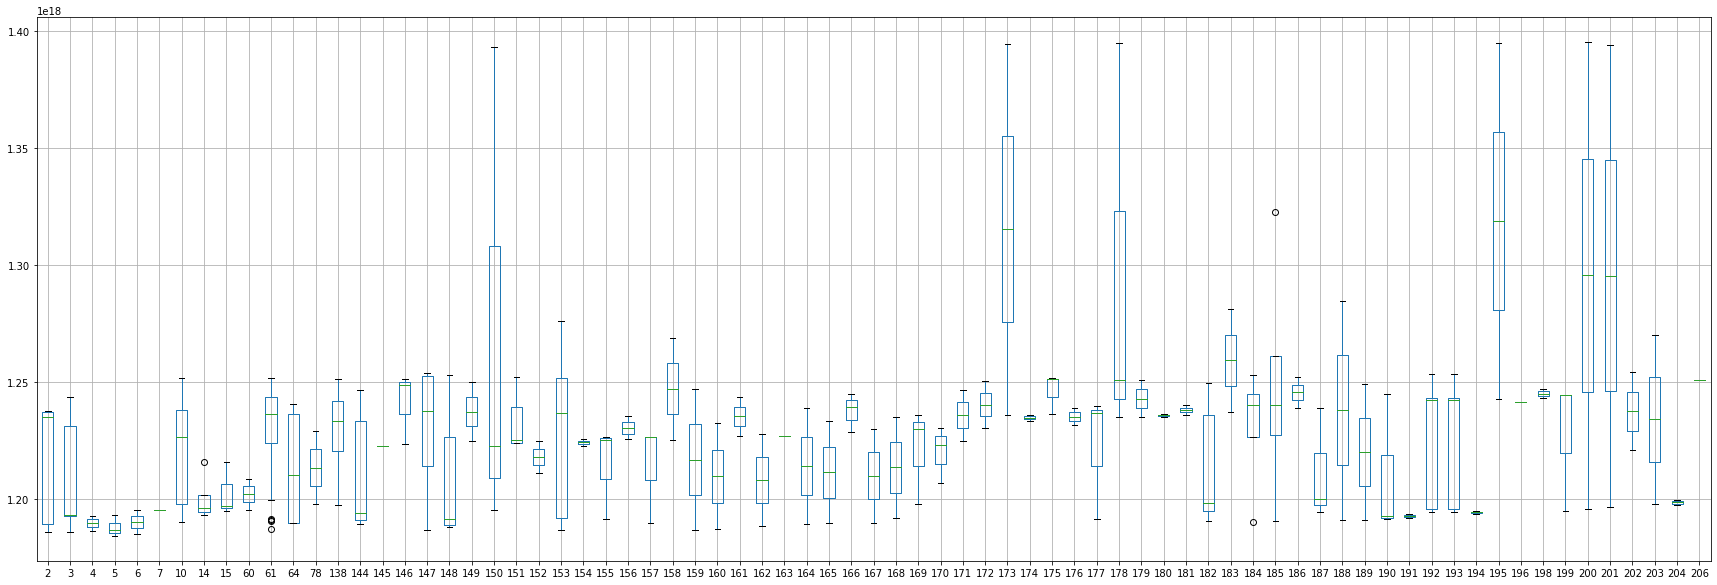

In [44]:
new = group_date.pivot(values = 'Date_int', index = None, columns = 'Group')
#new
boxplot = new.boxplot(column = valid_groups, figsize = (30,10))
boxplot

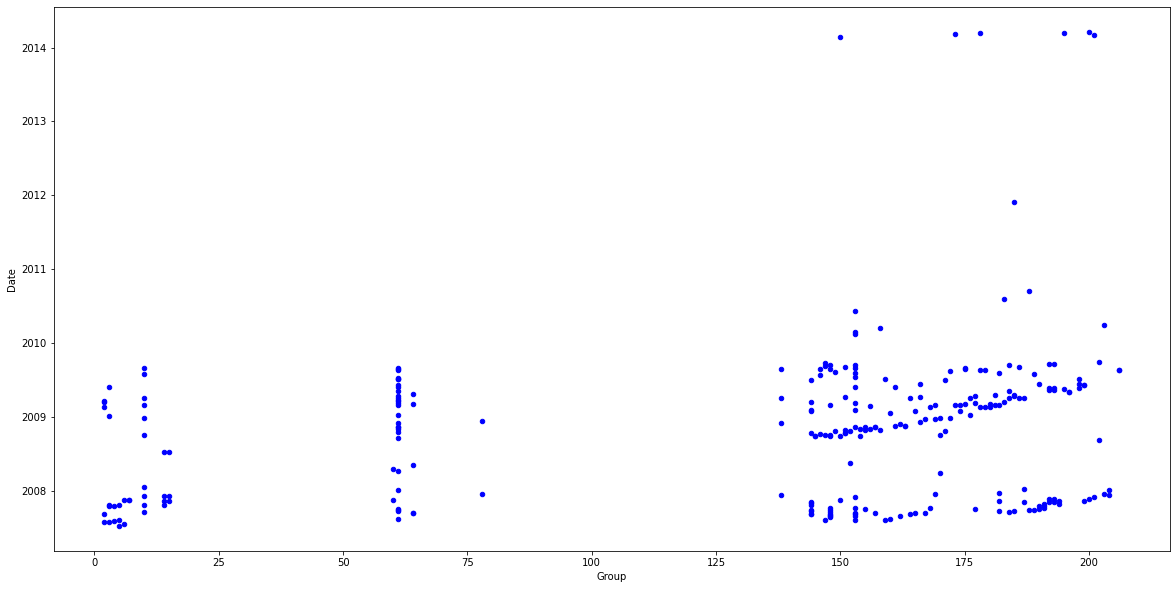

In [35]:
ax1 = group_date.plot.scatter(x='Group', y='Date',c='Blue', figsize = (20,10))
ax1

# <h2> Further Investigation for Groups with Member Size > 2 </h2>

In [87]:
#Create a list of (length, group) tuples where length is size of the group and group is the corresponding group number.
#We only take those which have length > 2
member_sorted = []
for pair in dup_fen_full_to_ids:
    length = len(dup_fen_full_to_ids[pair])
    if length > 2:
        pos = dup_fen_full_list.index(pair)
        group = temp.iloc[pos,1]
        if group in valid_groups:
            member_sorted.append((length,group))
            
member_sorted.sort(reverse = True)
member_sorted

[(28, 61),
 (17, 153),
 (12, 148),
 (12, 144),
 (11, 10),
 (8, 138),
 (5, 193),
 (5, 192),
 (5, 182),
 (5, 151),
 (5, 64),
 (5, 14),
 (5, 3),
 (5, 2),
 (4, 185),
 (4, 184),
 (4, 147),
 (4, 15),
 (3, 199),
 (3, 198),
 (3, 191),
 (3, 190),
 (3, 187),
 (3, 178),
 (3, 177),
 (3, 175),
 (3, 170),
 (3, 169),
 (3, 166),
 (3, 157),
 (3, 155),
 (3, 150),
 (3, 146),
 (3, 78),
 (3, 5)]

In [88]:
#Put the sorted groups in group_large_member_sorted, and the lengths in size_large_member_sorted
group_large_member_sorted = []
size_large_member_sorted = []
for pair in member_sorted:
    group_large_member_sorted.append(pair[1])
    size_large_member_sorted.append(pair[0])

In [89]:
temp[temp['Group'] == 35]

,tactics_problem_id,Group,"(FEN,FULL)",rating,rd,attempt_count,average_seconds,move_count,tags,pgn,...,Event,Site,Date,Round,White,Black,Result,FirstMove,PlyCount,SetUp
89,29235,35,"(' 1Q6/6pk/8/3p1R2/pp1b2P1/7P/P5PK/4q3 w - -',...",1514,45.01,61738,37,3,"Basic Checkmates,Discovered Attack,Endgame Tac...","[Event ""?""]\n[Site ""Santa Clara (09)""]\n[Date ...",...,?,Santa Clara (09),1991.??.??,?,Estevez G,Antunes A,0-1,44w,6.0,1.0
90,32088,35,"(' 1Q6/6pk/8/3p1R2/pp1b2P1/7P/P5PK/4q3 w - -',...",1467,45.02,61607,38,3,"Basic Checkmates,Discovered Attack,Interferenc...","[Event ""?""]\n[Site ""Santa Clara (09)""]\n[Date ...",...,?,Santa Clara (09),1991.??.??,?,Estevez G,Antunes A,0-1,44w,6.0,1.0
91,32100,35,"(' 1Q6/6pk/8/3p1R2/pp1b2P1/7P/P5PK/4q3 w - -',...",1547,45.22,59978,37,3,"Attacking Castled King,Basic Checkmates,Discov...","[Event ""?""]\n[Site ""Santa""]\n[Date ""1991.??.??...",...,?,Santa,1991.??.??,9,Estevez Morales G,Antunes A,0-1,44w,6.0,1.0


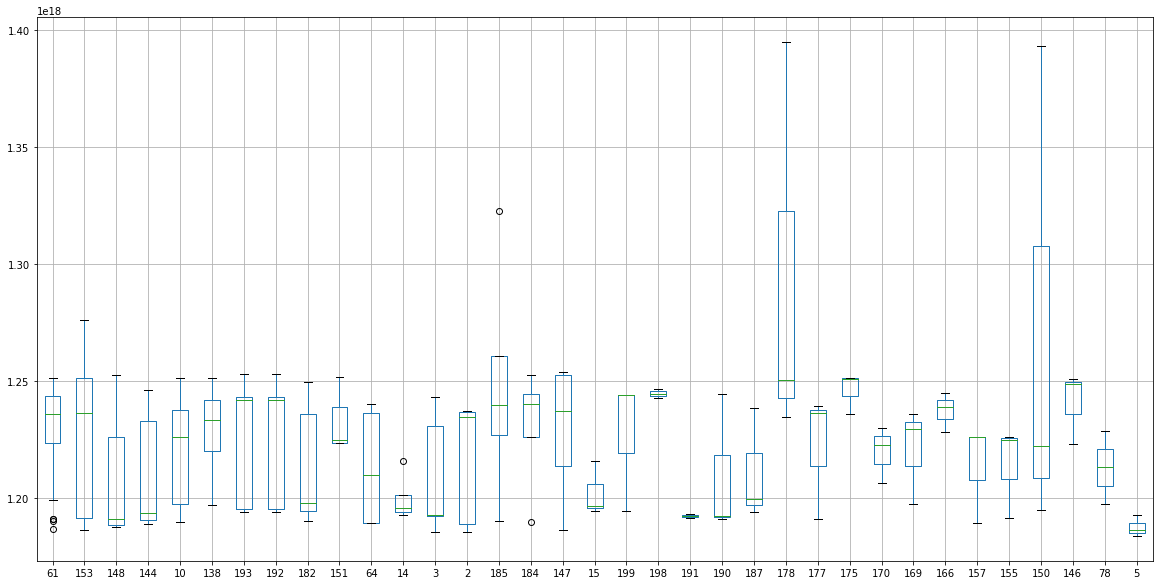

In [54]:
boxplot_large_member = new.boxplot(column = group_large_member_sorted, figsize = (20,10))
boxplot_large_member

In [2]:
#Create a dictionary that maps each group to its corresponding standard deviation of dates in seconds, and another
#dictionary that maps each group to its corresponding standard deviation of dates in days
group_list = list(res.index)
group_to_std_seconds = {}
group_to_std_days = {}
for i in range(len(group_list)):
    group_to_std_seconds[group_list[i]] = std_list[i].total_seconds()
    group_to_std_days[group_list[i]] = std_list[i].days

NameError: name 'res' is not defined

In [112]:
data_large_member = pd.DataFrame({'Group': group_large_member_sorted, 'Member Size': size_large_member_sorted})
data_large_member['Std in Seconds'] = np.vectorize(group_to_std_seconds.get)(list(data_large_member['Group']))
data_large_member['Std in Days'] = np.vectorize(group_to_std_days.get)(list(data_large_member['Group']))
data_large_member.to_csv("data_large_member.csv", index = False)

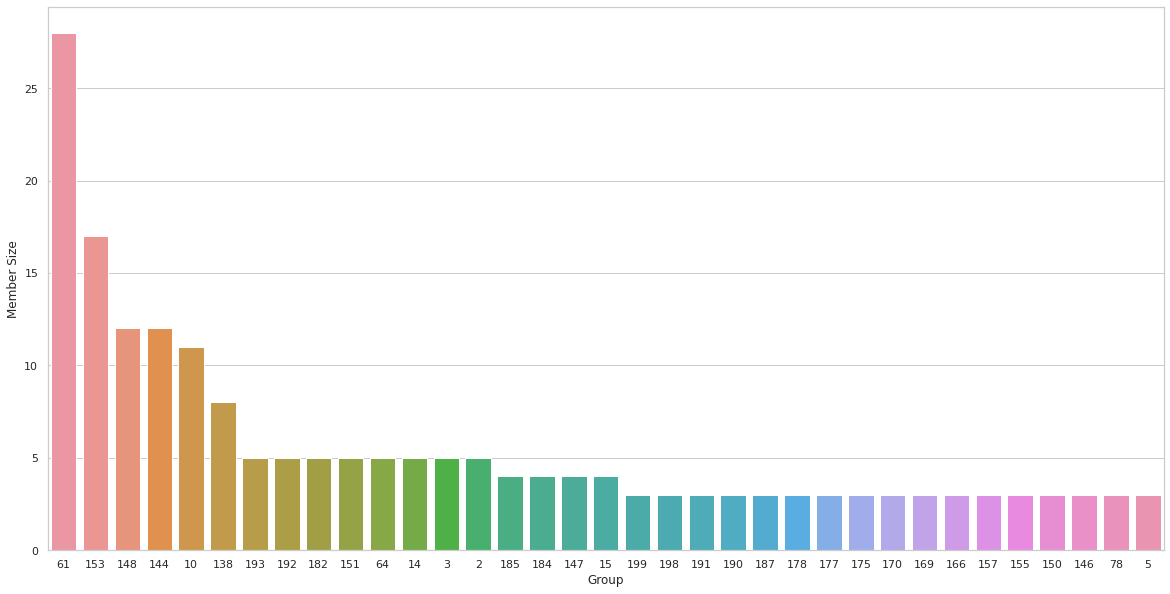

In [104]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,10))
sns.set(style="whitegrid")
ax = sns.barplot(x="Group", y="Member Size", order = group_large_member_sorted, data=data_large_member)

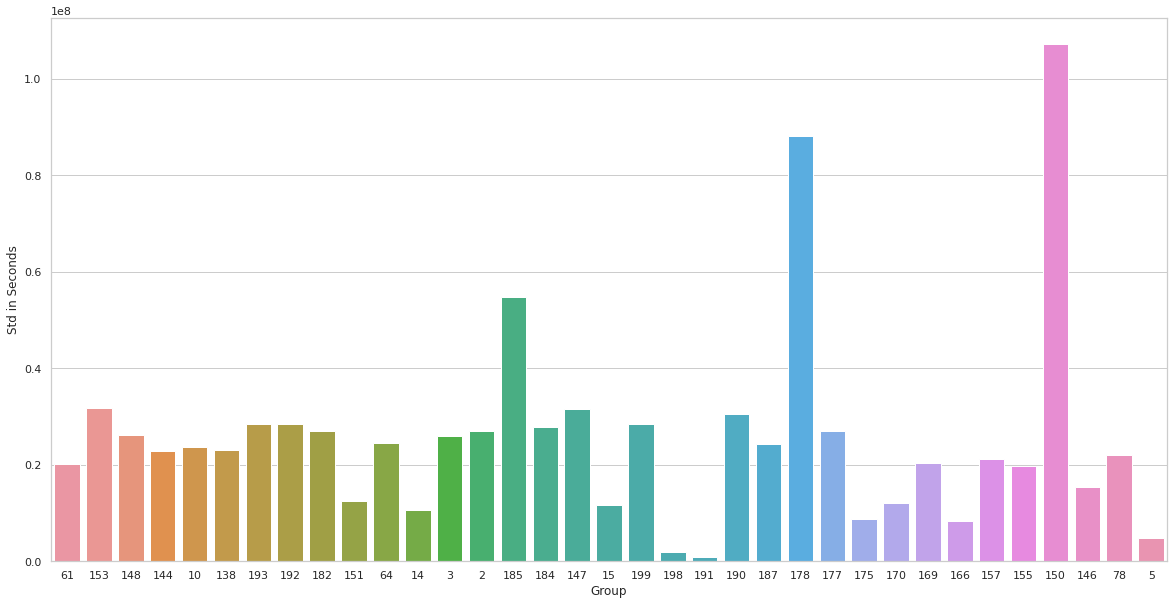

In [106]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,10))
sns.set(style="whitegrid")
ax = sns.barplot(x="Group", y="Std in Seconds", order = group_large_member_sorted, data=data_large_member)

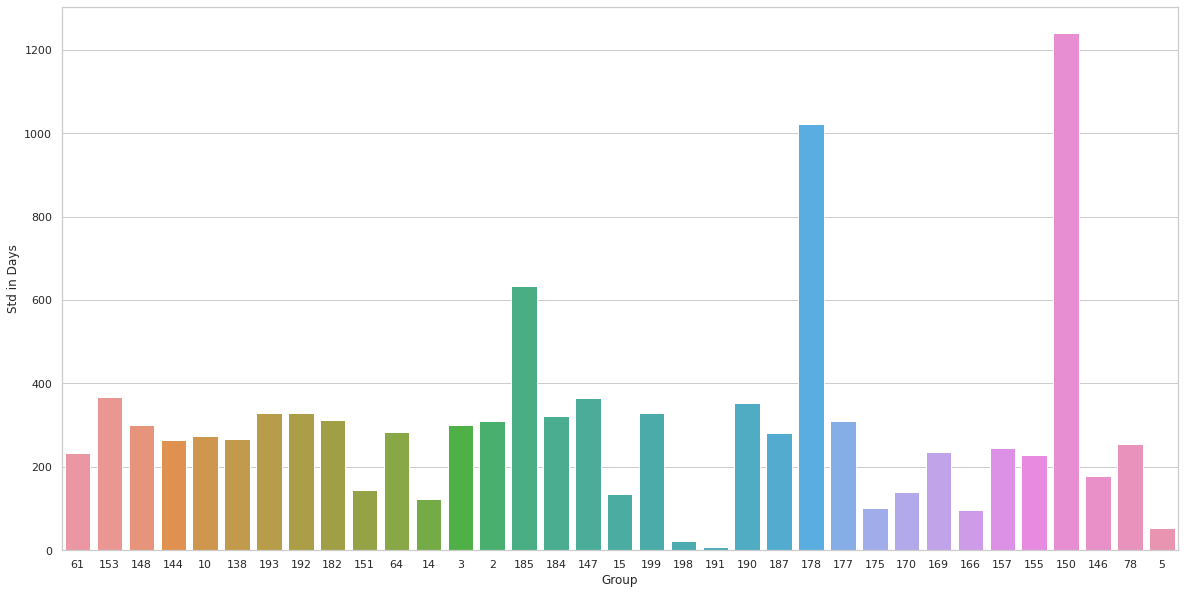

In [107]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,10))
sns.set(style="whitegrid")
ax = sns.barplot(x="Group", y="Std in Days", order = group_large_member_sorted, data=data_large_member)

# <h2> Date, Event, Site </h2>

In [158]:
#These are the groups that we need to investigate further based on the previous result
groups_to_investigate = [7,145,163,196,206] 

In [164]:
new_data = temp[['Group','Date','Event','Site']]
new_data = new_data[new_data['Group'].isin(groups_to_investigate)]
new_data

,Group,Date,Event,Site
19,7,2007.11.13,Online Chess,Chess.com
20,7,2007.11.13,Online Chess,Chess.com
365,145,2008.09.28,Online Chess,Chess.com
366,145,2008.09.28,Online Chess,Chess.com
435,163,2008.11.13,Let's Play!,Chess.com
436,163,2008.11.13,Let's Play!,Chess.com
523,196,2009.05.04,Online Chess,Chess.com
524,196,2009.05.04,Let's Play!,Chess.com
545,206,2009.08.18,Online Chess,Chess.com
546,206,2009.08.18,Let's Play!,Chess.com


In [108]:
x = temp[temp['Group'].isin([7,145,163])]
x = x[['tactics_problem_id', 'Group', 'tags']]
x

,tactics_problem_id,Group,tags
19,27720,7,Defense
20,128972,7,"Basic Checkmates,Defense,Simplification,Vulner..."
365,43095,145,Mate in 2
366,43096,145,Mate in 2
435,54358,163,Fork / Double Attack
436,54359,163,Fork / Double Attack


# <h2> MRR for Exact Duplicates </h2>

In [6]:
#temp = pd.read_csv('embeddings/250_0.16_vectors.tsv', sep=' ', header=None, skiprows=1)
temp = pd.read_csv("/h/224/stevenhl/chess_dim_skill/src/word2vecf/vectors/size_alpha/vecs_0.16_265.txt", sep=' ', header=None, skiprows=1)
temp = temp.drop(len(temp.columns)-1,axis=1)
problem_id = list(temp[0])
temp.rename(columns={0:'puzzle_id'}, inplace=True)
puzzle_id = list(temp['puzzle_id'])
temp.set_index('puzzle_id',inplace=True)
temp = temp.divide(np.linalg.norm(temp, axis=1), axis=0)

In [81]:
#Sample tags and generate distance matrix of those tags
import sklearn.metrics
def generate_matrix(sampled_problems):
    vecs = temp.loc[sampled_problems]
    cos_sim = sklearn.metrics.pairwise.cosine_similarity(vecs)
    cos_dist = 1.0 - cos_sim
    #Set really small numbers to 0
    cos_dist=cos_dist.round(3)
    #Create cosine distance table
    table = pd.DataFrame(cos_dist, columns=sampled_problems,index=sampled_problems)
    return table

In [82]:
table = generate_matrix(puzzle_id)

In [83]:
#Create a new table which is a modified version of table. The difference lies in the columns, where each column is
#the IDs in duplicate_data_id above. Basically, new_table is a "subset" of table. Note that the rows are still exactly
#the same as above since otherwise, the ranking won't be accurate.

new_table = pd.DataFrame(table, columns = target_problems)
new_table

,752,765,26689,56297,65759,97621,112114,26857,64496,117179,...,144169,193972,146228,281403,156943,172228,175089,304717,177491,288407
731,0.839,0.861,0.782,0.845,0.828,0.888,0.835,0.804,0.879,0.843,...,0.625,0.634,0.803,0.838,0.418,0.524,NaN,NaN,0.500,0.684
746,0.720,0.778,0.834,0.835,0.746,0.765,0.784,0.900,0.906,0.755,...,0.719,0.703,0.698,0.791,0.846,0.782,NaN,NaN,0.750,0.805
27811,0.827,0.808,0.868,0.845,0.758,0.801,0.786,0.935,0.930,0.731,...,0.759,0.755,0.693,0.802,0.842,0.808,NaN,NaN,0.763,0.806
905,0.722,0.748,0.816,0.830,0.774,0.767,0.823,0.905,0.914,0.762,...,0.729,0.731,0.707,0.811,0.831,0.765,NaN,NaN,0.753,0.781
48779,0.867,0.817,0.880,0.886,0.779,0.789,0.777,0.933,0.889,0.769,...,0.794,0.744,0.750,0.790,0.860,0.809,NaN,NaN,0.802,0.829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386259,0.493,0.485,0.518,0.551,0.521,0.542,0.568,0.565,0.556,0.557,...,0.475,0.472,0.437,0.524,0.430,0.457,NaN,NaN,0.384,0.493
391319,0.494,0.474,0.505,0.528,0.497,0.515,0.543,0.545,0.523,0.523,...,0.460,0.463,0.463,0.536,0.446,0.478,NaN,NaN,0.402,0.502
397091,0.564,0.540,0.524,0.554,0.531,0.564,0.550,0.573,0.549,0.527,...,0.411,0.407,0.522,0.595,0.478,0.518,NaN,NaN,0.418,0.529
408141,0.507,0.483,0.514,0.530,0.513,0.532,0.554,0.557,0.544,0.527,...,0.426,0.435,0.514,0.576,0.445,0.499,NaN,NaN,0.418,0.506


In [84]:
r,c = new_table.shape

#temp is a matrix which is similar to new_table, except that each entry is a tuple of distance and its corresponding
#problem ID. The ordering for the tuple is (distance, problem_ID).
temp = np.empty([r,c], dtype = object)

for i in tqdm(range(r)):
    for j in range(c):
        temp[i][j] = (new_table.iloc[i,j], problem_id[i])

In [85]:
temp1 = np.sort(temp, axis = 0)

In [88]:
r,c = new_table.shape
reciprocal_rank_fen_full = []
rank_fen_full = []

for i in tqdm(range(len(duplicate_fen_full_id_to_id))):
    current_id = duplicate_fen_full_id_to_id[i][0] #get the ID on the left as the current
    target_id = duplicate_fen_full_id_to_id[i][1] #get the ID on the right as the target
    pos = target_problems.index(current_id) #find the column position
    if temp1[0][pos][0] != 'nan': #if a column consists of nan, then it's invalid
        for j in range(r):
            if target_id == temp1[j][pos][1]:
                rank_fen_full.append(j+1)
                reciprocal_rank_fen_full.append(1./(j+1))

In [90]:
mean_reciprocal_rank_fen_full = sum(reciprocal_rank_fen_full) / len(reciprocal_rank_fen_full)
mean_reciprocal_rank_fen_full

0.002664304364590566

(array([1.878e+03, 5.600e+01, 3.100e+01, 1.800e+01, 8.000e+00, 1.000e+00,
        6.000e+00, 6.000e+00, 1.000e+00, 7.000e+00, 1.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

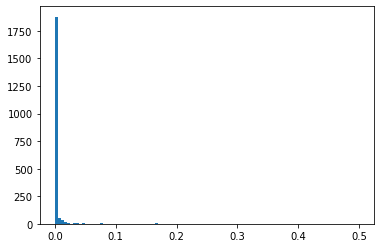

In [95]:
import matplotlib.pyplot as plt
plt.hist(reciprocal_rank_fen_full, bins = 100)

(array([5., 4., 5., ..., 0., 0., 2.]),
 array([2.00000000e+00, 6.06190000e+00, 1.01238000e+01, ...,
        4.06128762e+04, 4.06169381e+04, 4.06210000e+04]),
 <a list of 10000 Patch objects>)

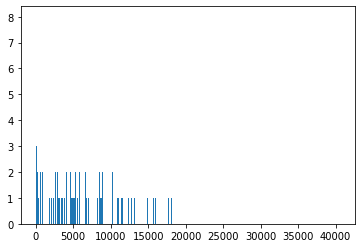

In [93]:
plt.hist(rank_fen_full, bins = 1000)